# 필요한 모듈 설치

In [ ]:
!pip install joblib
!pip install tqdm
!pip install koreanize-matplotlib
!pip install lightgbm

# 필요한 모듈들 import

In [ ]:
# 시스템 및 환경 설정
import os  # 파일 및 경로 관리
import random  # 랜덤 함수 제공
import pytz  # 시간대 처리
from tqdm import tqdm  # 진행 바 표시

# 날짜 및 시간 처리
from datetime import datetime
today = datetime.today().strftime('%m%d')

# 데이터 분석 및 처리
import pandas as pd  # 데이터프레임 활용
import numpy as np  # 수학 연산 및 배열 연산
from collections import Counter  # 데이터 개수 세기

# 데이터 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib  # Matplotlib 한글 폰트 지원

# 머신러닝 및 딥러닝
import lightgbm as lgb
import torch  # PyTorch

# 데이터 전처리 및 모델 평가
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE  # 오버샘플링 기법

# Seed 고정 함수
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# 제출 파일명 자동 생성 함수
def get_submission_filename(base_path, base_filename):
    counter = 1
    submission_path = os.path.join(base_path, f"{base_filename}_{today}_{counter}.csv")
    while os.path.exists(submission_path):
        counter += 1
        submission_path = os.path.join(base_path, f"{base_filename}_{today}_{counter}.csv")
    return submission_path


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Connect to googld drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Global Variables

In [ ]:
import easydict
args = easydict.EasyDict()

# path info
args.default_path = "/content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/kaggle/data/"
args.train_csv = args.default_path + "train.csv"
args.test_csv = args.default_path + "test.csv"
args.default_submission = args.default_path + "submission.csv"
args.submit_submission = "/content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/kaggle/submission_csv/"

# 결과 저장 경로 설정
history_results_dir = "/content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/kaggle/"
history_results_path = os.path.join(history_results_dir, "history_results.csv")

# 제출용
args.submission_csv = get_submission_filename(args.submit_submission, "submission")

# 기타 설정
args.random_seed = 42

# 추후의 확인을 위한 리스트
args.results = []

# 여러 모델들을 실험하게 될텐데 최종 결과를 보고 헷갈리지 않도록 설정
model_name = ''

# 한국 타임존 설정
kst = pytz.timezone('Asia/Seoul')


# Load Titanic Dataset
- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- gender:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [ ]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)
default_submission = pd.read_csv(args.default_submission)

ori_train.shape, ori_test.shape, default_submission.shape

((916, 12), (393, 11), (393, 2))

In [ ]:
default_submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [ ]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [ ]:
ori_train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [ ]:
ori_test.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

- test 데이터셋에는 survived가 없음을 알 수 있음
- train 데이터셋에서 훈련을 위한 데이터프레임과 검증을 위한 데이터프레임을 나눠야 함.

# model_lgbm_V2 (random search 진행) / submission_0212_8.csv
- encoding X
- StandardScaler O

## Train & Test Split

In [ ]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [ ]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [ ]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

((732, 12), (184, 12))

## Data Preprocessing

In [ ]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [ ]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [ ]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Feature Extraction

#### pclass별 평균 나이

In [ ]:
# pclass별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_pclass'] = train.groupby('pclass')['age'].transform('mean')
test['avg_age_by_pclass'] = test.groupby('pclass')['age'].transform('mean')
ori_te['avg_age_by_pclass'] = ori_te.groupby('pclass')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 13) (184, 13) (393, 12)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018


#### embarked별 평균 나이

In [ ]:
# embarked별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_embarked'] = train.groupby('embarked')['age'].transform('mean')
test['avg_age_by_embarked'] = test.groupby('embarked')['age'].transform('mean')
ori_te['avg_age_by_embarked'] = ori_te.groupby('embarked')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 14) (184, 14) (393, 13)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433


#### pclass별 평균 요금

In [ ]:
# pclass별 평균 요금을 계산하여 새로운 컬럼 추가
train['avg_fare_by_pclass'] = train.groupby('pclass')['fare'].transform('mean')
test['avg_fare_by_pclass'] = test.groupby('pclass')['fare'].transform('mean')
ori_te['avg_fare_by_pclass'] = ori_te.groupby('pclass')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 15) (184, 15) (393, 14)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176


#### embarked별 평균 요금

In [ ]:
train['avg_fare_by_embarked'] = train.groupby('embarked')['fare'].transform('mean')
test['avg_fare_by_embarked'] = test.groupby('embarked')['fare'].transform('mean')
ori_te['avg_fare_by_embarked'] = ori_te.groupby('embarked')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 16) (184, 16) (393, 15)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418


#### 동승한 가족 인원수 컬럼 추가

In [ ]:
# sibsp : 동승한 형제/배우자의 수, parch: 동승한 부모/자녀의 수.
train['family_size'] = train['sibsp'] + train['parch'] + 1
test['family_size'] = test['sibsp'] + test['parch'] + 1
ori_te['family_size'] = ori_te['sibsp'] + ori_te['parch'] + 1

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 17) (184, 17) (393, 16)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1


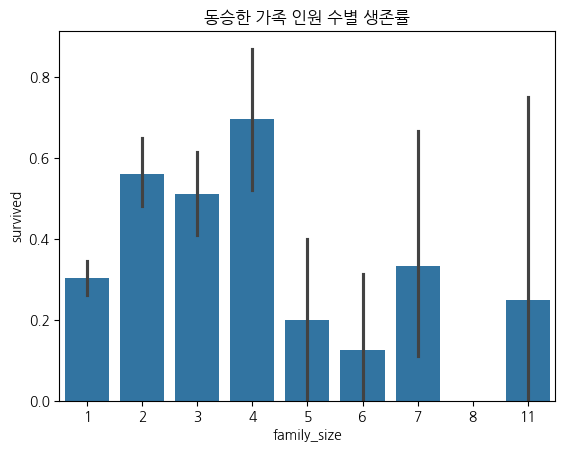

In [ ]:
sns.barplot(data=train, x='family_size', y='survived')
plt.title('동승한 가족 인원 수별 생존률')
plt.show()

#### 가족 인원 수를 기준으로 그룹화

In [ ]:
train['is_alone'] = (train['family_size'] == 1).astype(int)
test['is_alone'] = (test['family_size'] == 1).astype(int)
ori_te['is_alone'] = (ori_te['family_size'] == 1).astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 18) (184, 18) (393, 17)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1


#### cabin 컬럼의 값이 있으면 1, 없으면 0

In [ ]:
# Cabin 존재 여부를 나타내는 컬럼
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 19) (184, 19) (393, 18)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1,0


### Data Cleaning

In [ ]:
train.isnull().sum().sort_values(ascending=False)

,0
cabin,580
age,135
passengerid,0
is_alone,0
family_size,0
avg_fare_by_embarked,0
avg_fare_by_pclass,0
avg_age_by_embarked,0
avg_age_by_pclass,0
embarked,0


In [ ]:
test.isnull().sum().sort_values(ascending=False)

,0
cabin,138
age,45
avg_fare_by_embarked,1
avg_age_by_embarked,1
embarked,1
passengerid,0
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


In [ ]:
ori_te.isnull().sum().sort_values(ascending=False)

,0
cabin,296
age,83
embarked,1
avg_fare_by_embarked,1
avg_age_by_embarked,1
fare,1
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


In [ ]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked와 cabin에 대해 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

(914    21.414891
 805     6.000000
 255     1.000000
 769    70.500000
 527    35.000000
          ...    
 403     1.000000
 824    34.000000
 879    10.000000
 214    24.000000
 636    70.000000
 Name: age, Length: 732, dtype: float64,
 914     7.7333
 805    31.2750
 255    12.1833
 769     7.7500
 527     7.1250
         ...   
 403    15.7417
 824     8.0500
 879    24.1500
 214    79.2000
 636    71.0000
 Name: fare, Length: 732, dtype: float64,
 'S')

In [ ]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

# 'avg_fare_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'fare' 컬럼의 평균으로 결측치 대체
train['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
test['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
ori_te['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)

# 'avg_age_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'age' 컬럼의 평균으로 결측치 대체
train['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
test['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
ori_te['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

<ipython-input-93-e249aeb7e77b>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['age'].fillna(age_mean, inplace=True)
<ipython-input-93-e249aeb7e77b>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [ ]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 19) / (184, 19)
after: (732, 16) / (184, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone          

In [ ]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [ ]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin'],
      dtype='object')

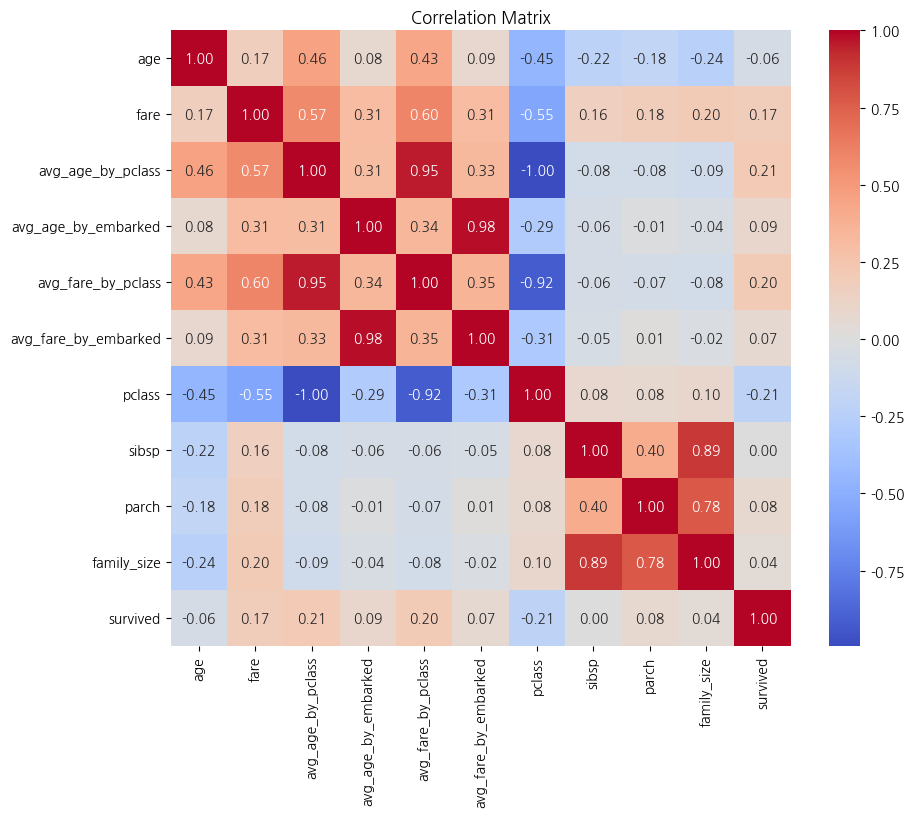

In [ ]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
    'pclass', 'sibsp', 'parch', 'family_size'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

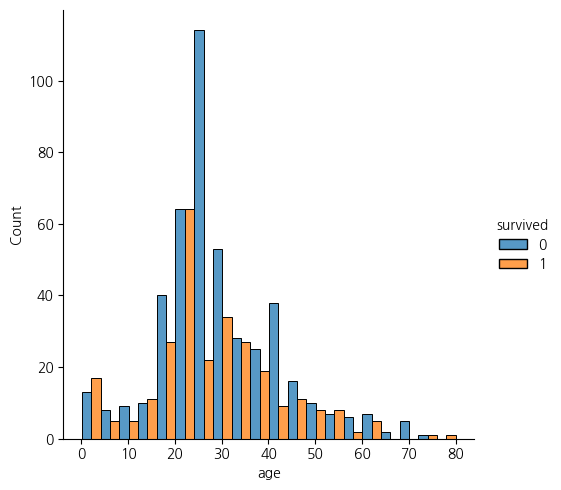

In [ ]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [ ]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5757575757575758

In [ ]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.2777777777777778

In [ ]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3676680972818312

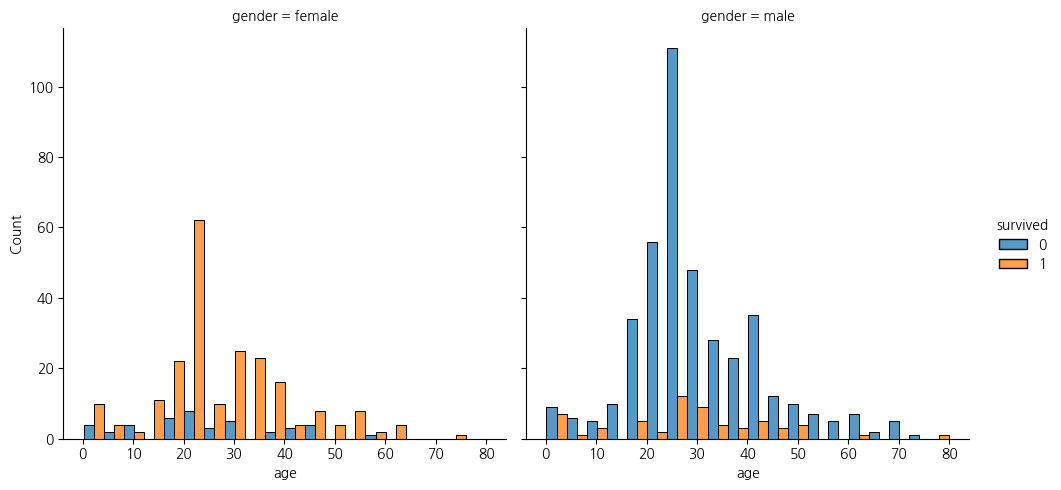

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 16), (184, 16), (393, 15)
컬럼 생성 이후 : (732, 17), (184, 17), (393, 16)


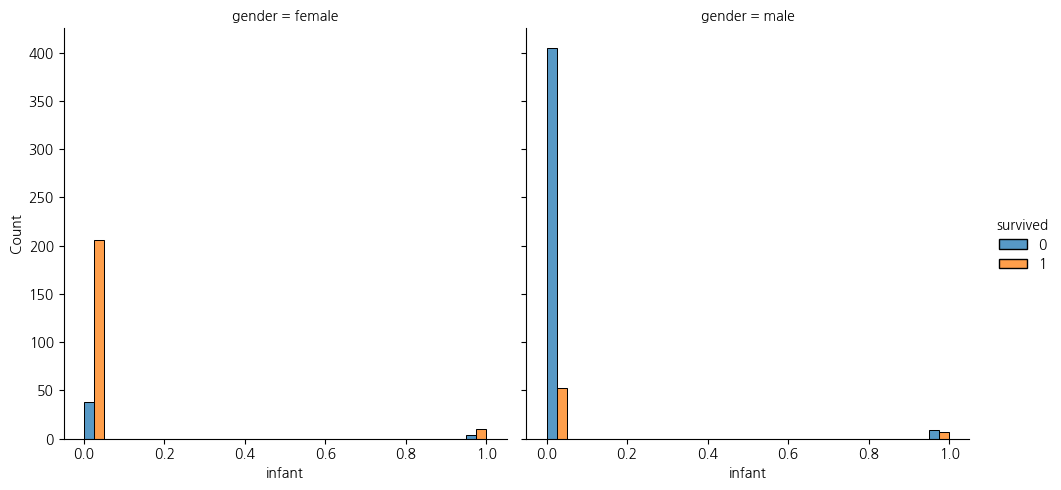

In [ ]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 17), (184, 17), (393, 16)
컬럼 생성 이후 : (732, 18), (184, 18), (393, 17)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0


##### pclass & gender

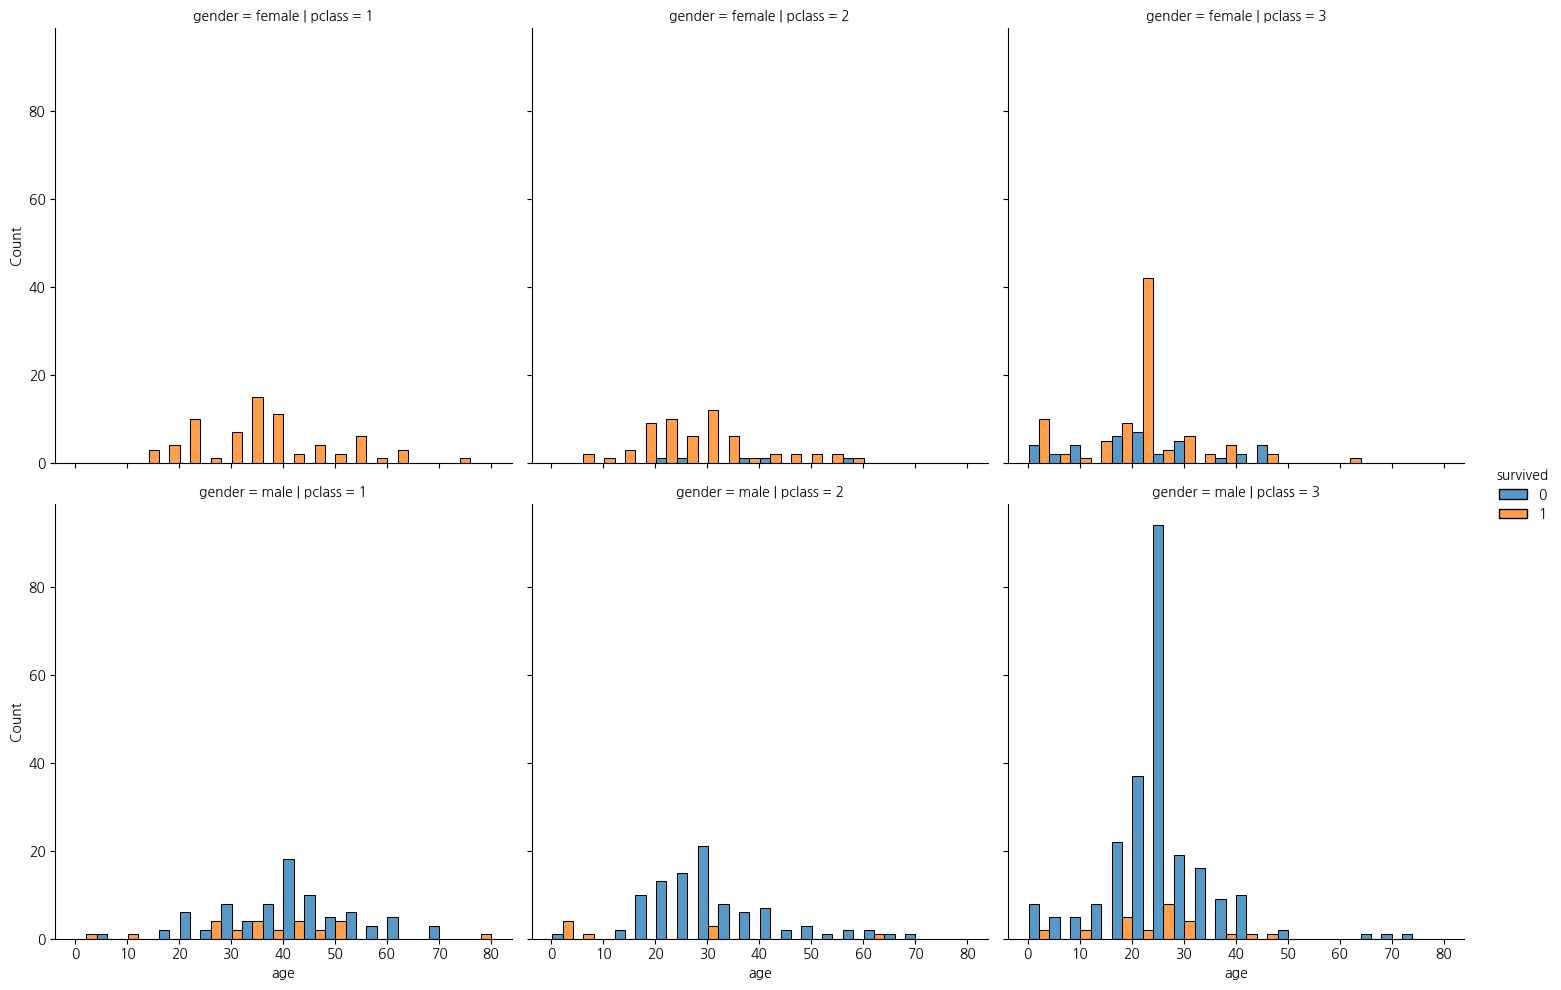

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 18), (184, 18), (393, 17)
컬럼 생성 이후 : (732, 19), (184, 19), (393, 18)


In [ ]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
       dtype='object'),
 19)

In [ ]:
train.shape, test.shape, ori_te.shape

((732, 19), (184, 19), (393, 18))

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [ ]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
      dtype='object')

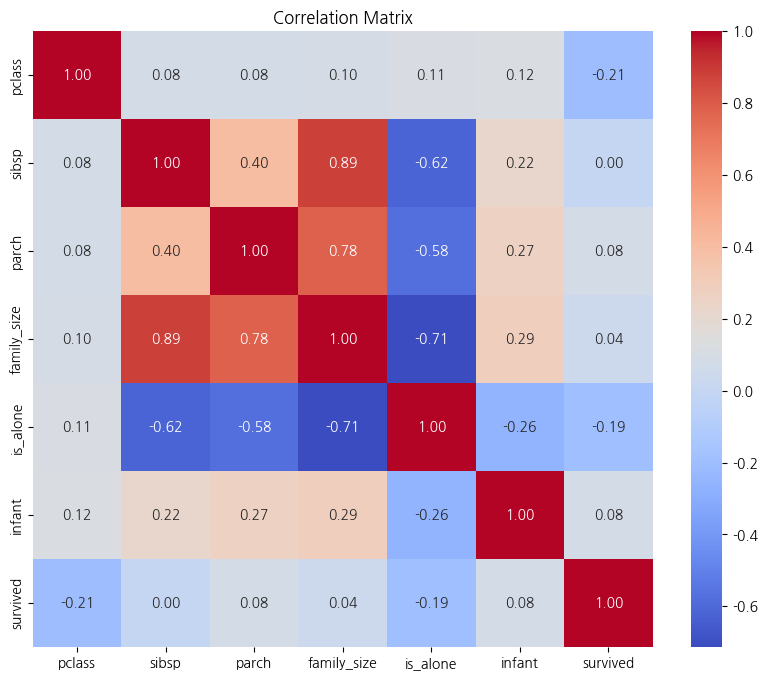

In [ ]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'family_size', 'is_alone', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 19), (184, 19), (393, 18)
컬럼 생성 이후 : (732, 20), (184, 20), (393, 19)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3


##### infant & family_size

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_family_size 컬럼 생성: 어린이 여부와 가족 크기 결합
train['infant_family_size'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
test['infant_family_size'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
ori_te['infant_family_size'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 20), (184, 20), (393, 19)
컬럼 생성 이후 : (732, 21), (184, 21), (393, 20)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3,0_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3,0_7
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3,1_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3,0_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3,0_1


##### pclass & is_alone

In [ ]:

print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_is_alone 컬럼 생성: 객실 등급과 단독 탑승 여부 결합
train['pclass_is_alone'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
test['pclass_is_alone'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
ori_te['pclass_is_alone'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 21), (184, 21), (393, 20)
컬럼 생성 이후 : (732, 22), (184, 22), (393, 21)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,14.147372,1,1,0,0,female_0,female_3,0_3,0_1,3_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,25.140418,7,0,0,0,female_0,female_3,0_3,0_7,3_0
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,25.140418,3,0,0,1,female_1,female_3,1_3,1_3,3_0
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,14.147372,1,1,0,0,male_0,male_3,0_3,0_1,3_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,25.140418,1,1,0,0,male_0,male_3,0_3,0_1,3_1


##### pclass_family_size

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_family_size 컬럼 생성: 객실 등급과 가족 크기 결합
train['pclass_family_size'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
test['pclass_family_size'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
ori_te['pclass_family_size'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 22), (184, 22), (393, 21)
컬럼 생성 이후 : (732, 23), (184, 23), (393, 22)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone,pclass_family_size
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,1,1,0,0,female_0,female_3,0_3,0_1,3_1,3_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,7,0,0,0,female_0,female_3,0_3,0_7,3_0,3_7
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,3,0,0,1,female_1,female_3,1_3,1_3,3_0,3_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1


In [ ]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### Scaling

In [ ]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'pclass', 'gender', 'age', 'sibsp', 'parch', 'fare',
        'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg

In [ ]:
print(f"train: {train.shape}, test: {test.shape}, ori_te: {ori_te.shape}")

train: (732, 23), test: (184, 23), ori_te: (393, 22)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

In [ ]:
# 범주형 변수
cat_features = ['pclass', 'gender', 'embarked', 'is_alone', 'has_cabin',
                'infant', 'gender_infant', 'gender_pclass', 'infant_pclass',
                'infant_family_size', 'pclass_is_alone', 'pclass_family_size']

# 수치형 변수만
num_features = ['age', 'sibsp', 'parch', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked',
                'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size']
len(cat_features), len(num_features)

(12, 9)

In [ ]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   passengerid           732 non-null    int64   
 1   survived              732 non-null    int64   
 2   pclass                732 non-null    category
 3   gender                732 non-null    category
 4   age                   732 non-null    float64 
 5   sibsp                 732 non-null    int64   
 6   parch                 732 non-null    int64   
 7   fare                  732 non-null    float64 
 8   embarked              732 non-null    category
 9   avg_age_by_pclass     732 non-null    float64 
 10  avg_age_by_embarked   732 non-null    float64 
 11  avg_fare_by_pclass    732 non-null    float64 
 12  avg_fare_by_embarked  732 non-null    float64 
 13  family_size           732 non-null    int64   
 14  is_alone              732 non-null    category
 15  has_cabin

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

((732, 22), (732,), (184, 22), (184,), (393, 22))

In [ ]:
print(f"before: {X_tr.shape}, {X_te.shape}, {ori_te.shape}")

scaler = StandardScaler()

X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()
ori_te_scaled = ori_te.copy()

X_tr_scaled[num_features] = scaler.fit_transform(X_tr[num_features])
X_te_scaled[num_features] = scaler.transform(X_te[num_features])
ori_te_scaled[num_features] = scaler.transform(ori_te[num_features])

print(f"after: {X_tr_scaled.shape}, {X_te_scaled.shape}, {ori_te_scaled.shape}")

before: (732, 22), (184, 22), (393, 22)
after: (732, 22), (184, 22), (393, 22)


## Training

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [ ]:
# reset_seeds()
# model_name = 'model_lgb_V1'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'n_estimators': list(range(400, 1001, 50)),
#     'max_depth': list(range(5, 31, 3)) + [None],
#     'num_leaves': list(range(20, 150, 10)),
#     'min_child_samples': list(range(5, 31, 5)),
#     'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 10],
#     'subsample': [0.5, 0.7, 0.9, 1.0],
#     'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'boosting_type': ['gbdt', 'dart'],
#     'objective': ['binary'],
#     'metric': ['auc']
# }

# # LightGBM 모델 초기화
# model_lgb_V1 = lgb.LGBMClassifier(random_state=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_lgb_V1, param_distributions=param_dist,
#     n_iter=100, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
# )

# random_search.fit(X_tr, y_tr)

In [ ]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [ ]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_lgb_V0_best = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
# print(f'{model_lgb_V0_best} : {X_tr.shape} / {y_tr.shape}')

# # 모델 학습
# model_lgb_V0_best.fit(X_tr, y_tr)

In [ ]:
reset_seeds()
model_name = 'model_lgb_V2'

parameters = {
    'subsample': 0.5,
    'objective': 'binary',
    'num_leaves': 30,
    'n_estimators': 550,
    'min_child_weight': 10,
    'min_child_samples': 15,
    'metric': 'auc',
    'max_depth': 29,
    'learning_rate': 0.01,
    'colsample_bytree': 0.5,
    'boosting_type': 'dart'
}

# LightGBM 모델 초기화
model_lgb_V2 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

model_lgb_V2.fit(X_tr_scaled, y_tr)

[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5)

## Evaluation (평가)

In [ ]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V2.score(X_tr_scaled, y_tr)
# - Test data
score_te_lgb = model_lgb_V2.score(X_te_scaled, y_te)

print(f'{model_lgb_V2} : {score_tr_lgb}, {score_te_lgb}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5) : 0.8688524590163934, 0.8695652173913043


### AUC 점수

In [ ]:
y_pred = model_lgb_V2.predict_proba(X_te_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V2}: {auc_te}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5): 0.9145363408521304


### 혼동행렬

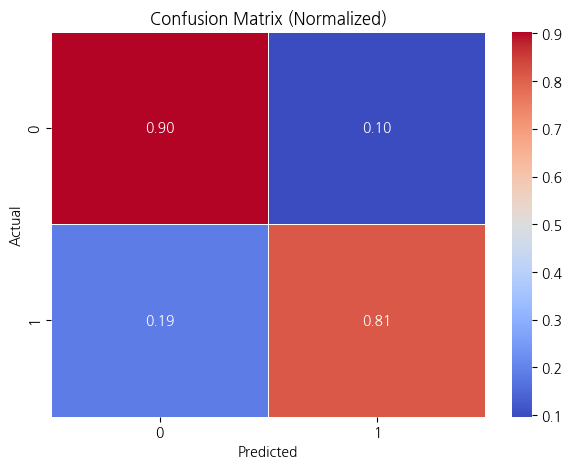

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgb_V2.predict(X_te_scaled)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [ ]:
ori_te_pred = model_lgb_V2.predict_proba(ori_te_scaled)[:,1]
ori_te_pred.shape

(393,)

### 특성 중요도

In [ ]:
df_feature_importances = pd.DataFrame(model_lgb_V2.feature_importances_, X_tr_scaled.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(22, 2)


,index,0
0,fare,1270
1,passengerid,1050
2,age,928
3,pclass,588
4,gender,277
5,embarked,275
6,avg_age_by_pclass,264
7,has_cabin,253
8,family_size,184
9,avg_fare_by_pclass,137


### 결과 정리

In [ ]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [ ]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

,model,parameters,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt,score_diff,auc_diff,total_diff
1,model_lgb_V2,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.868852,0.869565,0.914536,"[0.731556192254988, 0.6879417768146249, 0.7230...",22,"[fare, passengerid, age, pclass, gender, embar...",2025-02-13 12:15:50,0.000713,0.044971,0.045684
0,model_lgb_V0,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.867486,0.864130,0.919925,"[0.7421581077190138, 0.7425022455978721, 0.742...",81,"[passengerid, fare, age, avg_fare_by_pclass, p...",2025-02-13 12:15:34,0.003356,0.055794,0.059150


# model_lgbm_V10 (random search 진행) / submission_0213_7
- V2와의 차이 : 범주형 컬럼들이 무엇인지 명시하고, 훈련때 알려주기
- encoding X
- StandardScaler O

## Train & Test Split

In [ ]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [ ]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [ ]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

((732, 12), (184, 12))

## Data Preprocessing

In [ ]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [ ]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [ ]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Feature Extraction

#### pclass별 평균 나이

In [ ]:
# pclass별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_pclass'] = train.groupby('pclass')['age'].transform('mean')
test['avg_age_by_pclass'] = test.groupby('pclass')['age'].transform('mean')
ori_te['avg_age_by_pclass'] = ori_te.groupby('pclass')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 13) (184, 13) (393, 12)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018


#### embarked별 평균 나이

In [ ]:
# embarked별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_embarked'] = train.groupby('embarked')['age'].transform('mean')
test['avg_age_by_embarked'] = test.groupby('embarked')['age'].transform('mean')
ori_te['avg_age_by_embarked'] = ori_te.groupby('embarked')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 14) (184, 14) (393, 13)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433


#### pclass별 평균 요금

In [ ]:
# pclass별 평균 요금을 계산하여 새로운 컬럼 추가
train['avg_fare_by_pclass'] = train.groupby('pclass')['fare'].transform('mean')
test['avg_fare_by_pclass'] = test.groupby('pclass')['fare'].transform('mean')
ori_te['avg_fare_by_pclass'] = ori_te.groupby('pclass')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 15) (184, 15) (393, 14)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176


#### embarked별 평균 요금

In [ ]:
train['avg_fare_by_embarked'] = train.groupby('embarked')['fare'].transform('mean')
test['avg_fare_by_embarked'] = test.groupby('embarked')['fare'].transform('mean')
ori_te['avg_fare_by_embarked'] = ori_te.groupby('embarked')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 16) (184, 16) (393, 15)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418


#### 동승한 가족 인원수 컬럼 추가

In [ ]:
# sibsp : 동승한 형제/배우자의 수, parch: 동승한 부모/자녀의 수.
train['family_size'] = train['sibsp'] + train['parch'] + 1
test['family_size'] = test['sibsp'] + test['parch'] + 1
ori_te['family_size'] = ori_te['sibsp'] + ori_te['parch'] + 1

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 17) (184, 17) (393, 16)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1


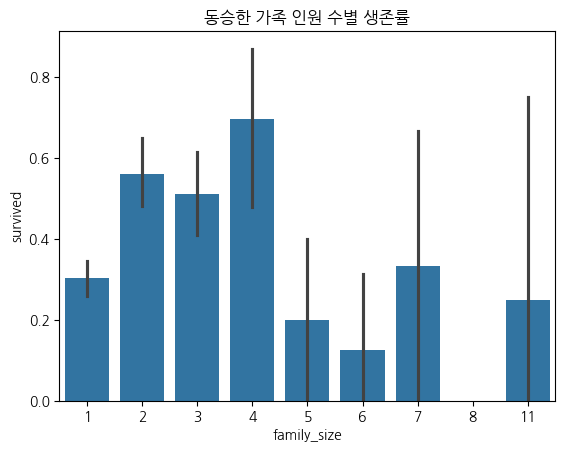

In [ ]:
sns.barplot(data=train, x='family_size', y='survived')
plt.title('동승한 가족 인원 수별 생존률')
plt.show()

#### 가족 인원 수를 기준으로 그룹화

In [ ]:
train['is_alone'] = (train['family_size'] == 1).astype(int)
test['is_alone'] = (test['family_size'] == 1).astype(int)
ori_te['is_alone'] = (ori_te['family_size'] == 1).astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 18) (184, 18) (393, 17)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1


#### cabin 컬럼의 값이 있으면 1, 없으면 0

In [ ]:
# Cabin 존재 여부를 나타내는 컬럼
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 19) (184, 19) (393, 18)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1,0


### Data Cleaning

In [ ]:
train.isnull().sum().sort_values(ascending=False)

,0
cabin,580
age,135
passengerid,0
is_alone,0
family_size,0
avg_fare_by_embarked,0
avg_fare_by_pclass,0
avg_age_by_embarked,0
avg_age_by_pclass,0
embarked,0


In [ ]:
test.isnull().sum().sort_values(ascending=False)

,0
cabin,138
age,45
avg_fare_by_embarked,1
avg_age_by_embarked,1
embarked,1
passengerid,0
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


In [ ]:
ori_te.isnull().sum().sort_values(ascending=False)

,0
cabin,296
age,83
embarked,1
avg_fare_by_embarked,1
avg_age_by_embarked,1
fare,1
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


In [ ]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked와 cabin에 대해 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

(914    21.414891
 805     6.000000
 255     1.000000
 769    70.500000
 527    35.000000
          ...    
 403     1.000000
 824    34.000000
 879    10.000000
 214    24.000000
 636    70.000000
 Name: age, Length: 732, dtype: float64,
 914     7.7333
 805    31.2750
 255    12.1833
 769     7.7500
 527     7.1250
         ...   
 403    15.7417
 824     8.0500
 879    24.1500
 214    79.2000
 636    71.0000
 Name: fare, Length: 732, dtype: float64,
 'S')

In [ ]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

# 'avg_fare_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'fare' 컬럼의 평균으로 결측치 대체
train['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
test['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
ori_te['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)

# 'avg_age_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'age' 컬럼의 평균으로 결측치 대체
train['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
test['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
ori_te['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

<ipython-input-371-e249aeb7e77b>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['age'].fillna(age_mean, inplace=True)
<ipython-input-371-e249aeb7e77b>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [ ]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 19) / (184, 19)
after: (732, 16) / (184, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone          

In [ ]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [ ]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin'],
      dtype='object')

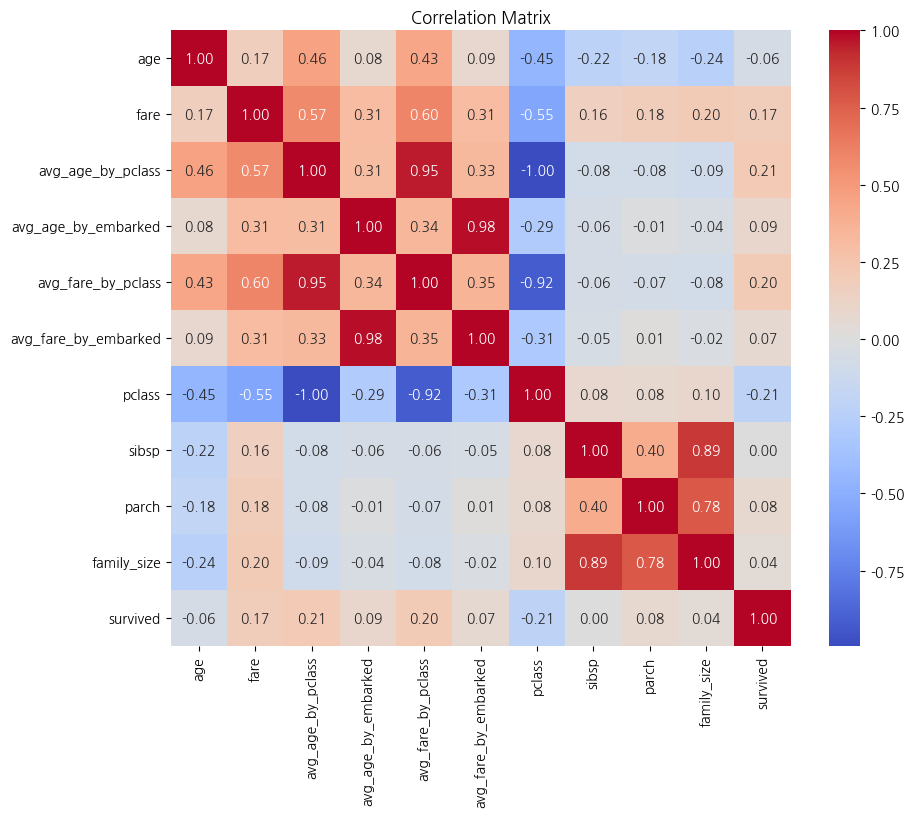

In [ ]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
    'pclass', 'sibsp', 'parch', 'family_size'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

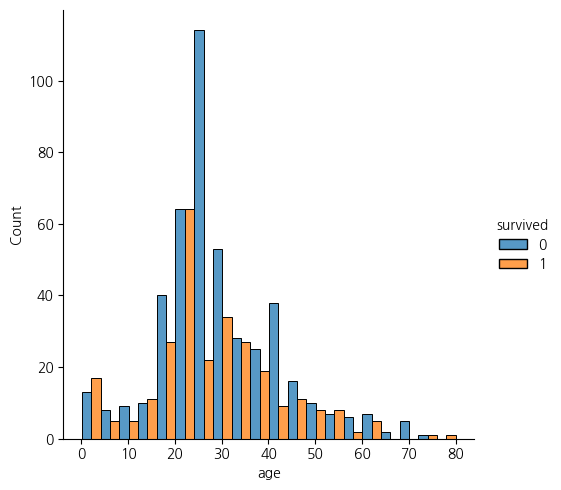

In [ ]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [ ]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5757575757575758

In [ ]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.2777777777777778

In [ ]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3676680972818312

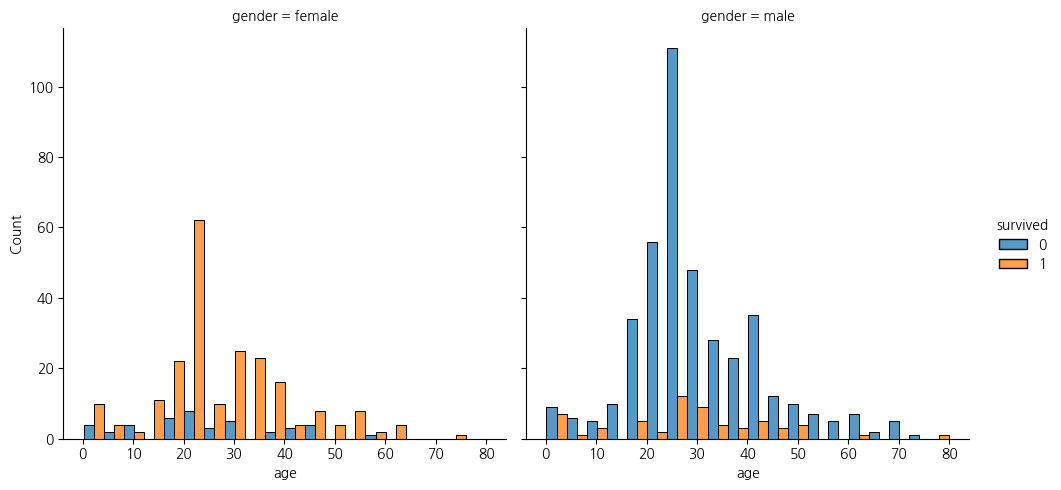

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 16), (184, 16), (393, 15)
컬럼 생성 이후 : (732, 17), (184, 17), (393, 16)


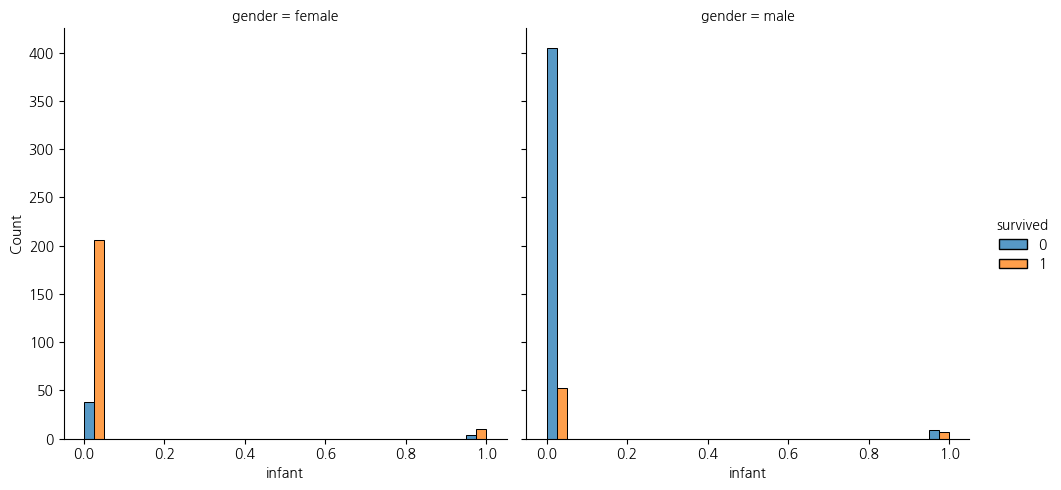

In [ ]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 17), (184, 17), (393, 16)
컬럼 생성 이후 : (732, 18), (184, 18), (393, 17)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0


##### pclass & gender

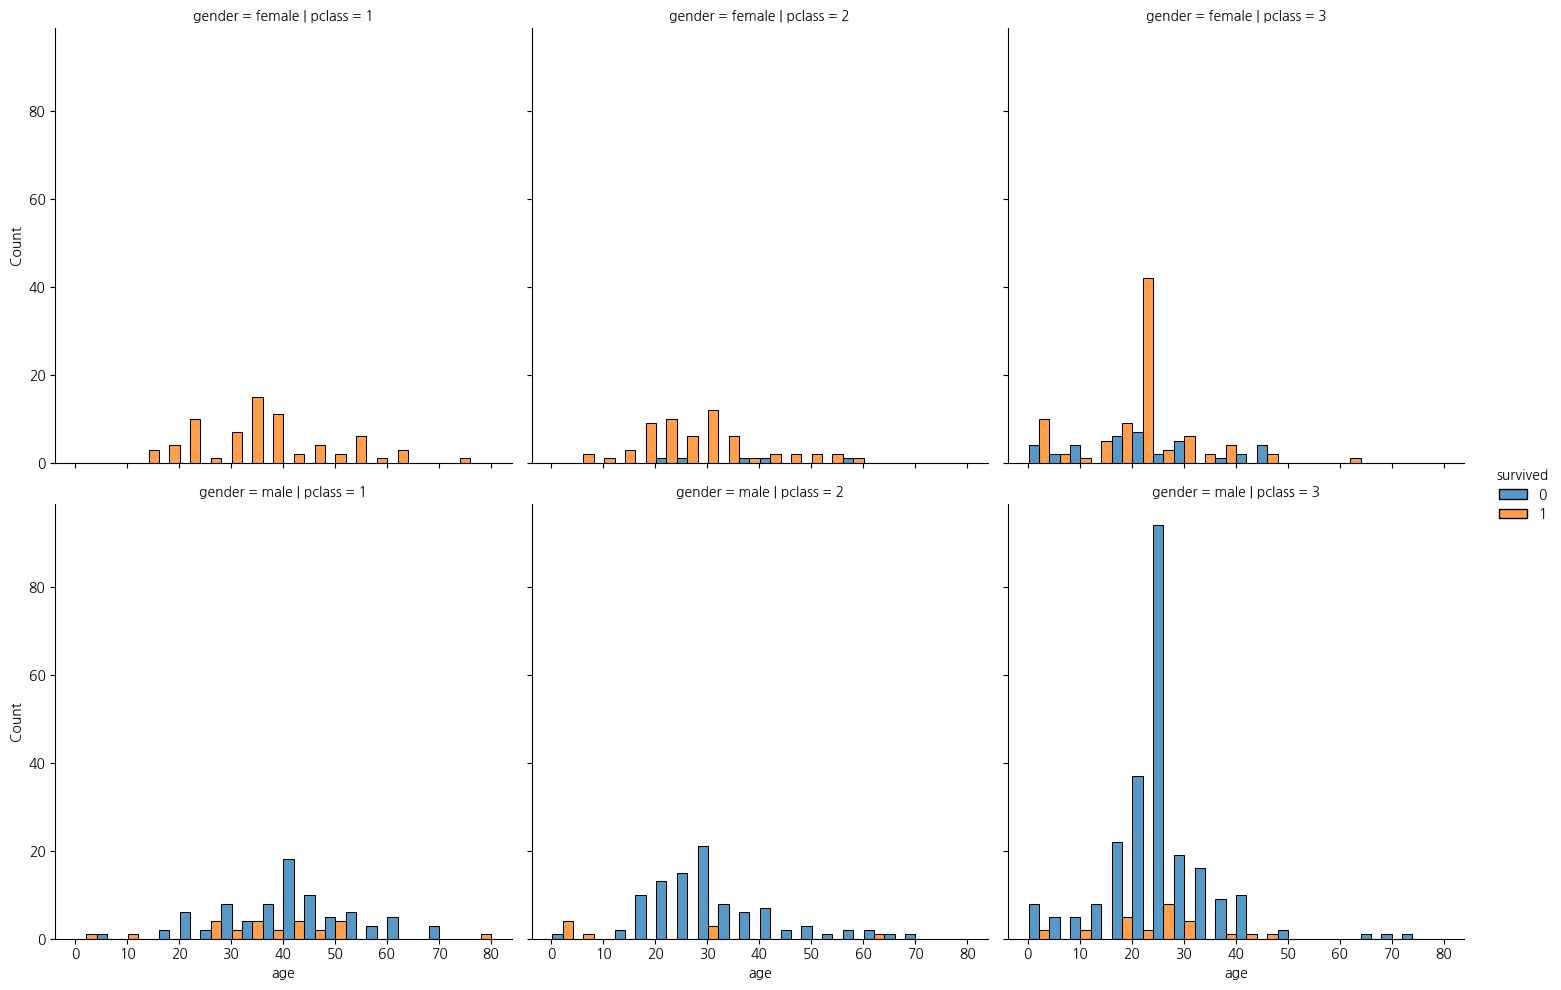

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 18), (184, 18), (393, 17)
컬럼 생성 이후 : (732, 19), (184, 19), (393, 18)


In [ ]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
       dtype='object'),
 19)

In [ ]:
train.shape, test.shape, ori_te.shape

((732, 19), (184, 19), (393, 18))

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [ ]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
      dtype='object')

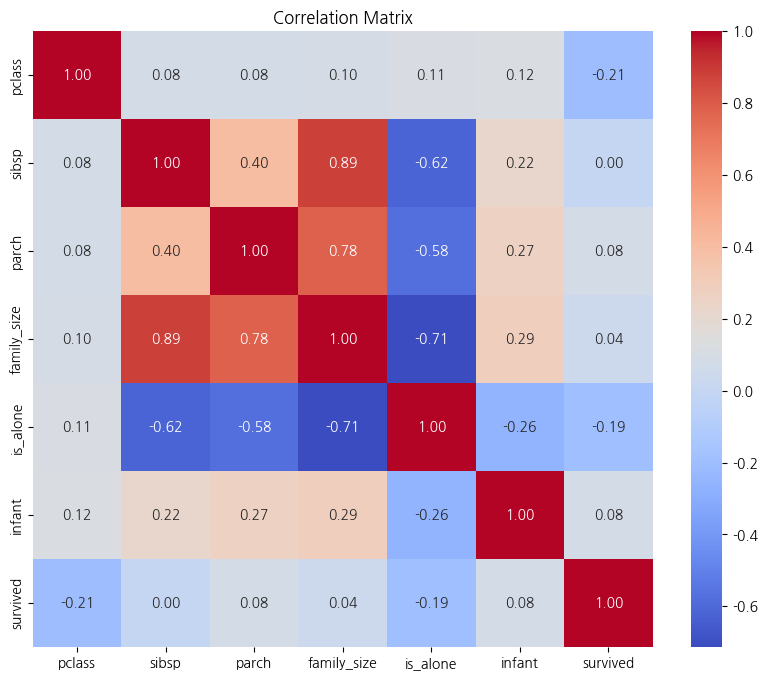

In [ ]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'family_size', 'is_alone', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 19), (184, 19), (393, 18)
컬럼 생성 이후 : (732, 20), (184, 20), (393, 19)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3


##### infant & family_size

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_family_size 컬럼 생성: 어린이 여부와 가족 크기 결합
train['infant_family_size'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
test['infant_family_size'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
ori_te['infant_family_size'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 20), (184, 20), (393, 19)
컬럼 생성 이후 : (732, 21), (184, 21), (393, 20)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3,0_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3,0_7
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3,1_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3,0_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3,0_1


##### pclass & is_alone

In [ ]:

print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_is_alone 컬럼 생성: 객실 등급과 단독 탑승 여부 결합
train['pclass_is_alone'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
test['pclass_is_alone'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
ori_te['pclass_is_alone'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 21), (184, 21), (393, 20)
컬럼 생성 이후 : (732, 22), (184, 22), (393, 21)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,14.147372,1,1,0,0,female_0,female_3,0_3,0_1,3_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,25.140418,7,0,0,0,female_0,female_3,0_3,0_7,3_0
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,25.140418,3,0,0,1,female_1,female_3,1_3,1_3,3_0
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,14.147372,1,1,0,0,male_0,male_3,0_3,0_1,3_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,25.140418,1,1,0,0,male_0,male_3,0_3,0_1,3_1


##### pclass_family_size

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_family_size 컬럼 생성: 객실 등급과 가족 크기 결합
train['pclass_family_size'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
test['pclass_family_size'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
ori_te['pclass_family_size'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 22), (184, 22), (393, 21)
컬럼 생성 이후 : (732, 23), (184, 23), (393, 22)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone,pclass_family_size
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,1,1,0,0,female_0,female_3,0_3,0_1,3_1,3_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,7,0,0,0,female_0,female_3,0_3,0_7,3_0,3_7
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,3,0,0,1,female_1,female_3,1_3,1_3,3_0,3_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1


In [ ]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### Scaling

In [ ]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'pclass', 'gender', 'age', 'sibsp', 'parch', 'fare',
        'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg

In [ ]:
print(f"train: {train.shape}, test: {test.shape}, ori_te: {ori_te.shape}")

train: (732, 23), test: (184, 23), ori_te: (393, 22)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

In [ ]:
print(f"{len(train.columns)}, {len(test.columns)}, {len(ori_te.columns)}")

# 범주형
cat_features = [
    'pclass', 'gender', 'embarked', 'sibsp', 'parch', 'has_cabin', 'infant',
    'is_alone', 'gender_infant', 'gender_pclass', 'infant_pclass',
    'infant_family_size', 'pclass_is_alone', 'pclass_family_size'
]

# 수치형
num_features = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked',
    'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size'
]

print(f"범주형 변수 개수: {len(cat_features)}, 수치형 변수 개수: {len(num_features)}")

excluded_features = set(train.columns) - set(cat_features) - set(num_features)
print(f"포함되지 않은 컬럼들: {excluded_features}")

23, 23, 22
범주형 변수 개수: 14, 수치형 변수 개수: 7
포함되지 않은 컬럼들: {'passengerid', 'survived'}


In [ ]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   passengerid           732 non-null    int64   
 1   survived              732 non-null    int64   
 2   pclass                732 non-null    category
 3   gender                732 non-null    category
 4   age                   732 non-null    float64 
 5   sibsp                 732 non-null    category
 6   parch                 732 non-null    category
 7   fare                  732 non-null    float64 
 8   embarked              732 non-null    category
 9   avg_age_by_pclass     732 non-null    float64 
 10  avg_age_by_embarked   732 non-null    float64 
 11  avg_fare_by_pclass    732 non-null    float64 
 12  avg_fare_by_embarked  732 non-null    float64 
 13  family_size           732 non-null    int64   
 14  is_alone              732 non-null    category
 15  has_cabin

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

((732, 22), (732,), (184, 22), (184,), (393, 22))

In [ ]:
print(f"before: {X_tr.shape}, {X_te.shape}, {ori_te.shape}")

scaler = StandardScaler()

X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()
ori_te_scaled = ori_te.copy()

X_tr_scaled[num_features] = scaler.fit_transform(X_tr[num_features])
X_te_scaled[num_features] = scaler.transform(X_te[num_features])
ori_te_scaled[num_features] = scaler.transform(ori_te[num_features])

print(f"after: {X_tr_scaled.shape}, {X_te_scaled.shape}, {ori_te_scaled.shape}")

before: (732, 22), (184, 22), (393, 22)
after: (732, 22), (184, 22), (393, 22)


## Training

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [ ]:
# reset_seeds()
# model_name = 'model_lgb_V10'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'n_estimators': list(range(400, 800, 50)),  # 최적값 600 기준 ±200 범위
#     'learning_rate': [0.005, 0.01, 0.02, 0.05],  # 작은 학습률
#     'max_depth': list(range(5, 20, 3)) + [None],  # 깊이 제한
#     'num_leaves': list(range(20, 150, 20)),  # 리프 노드 개수 최적화
#     'min_child_samples': list(range(10, 41, 5)),  # 최소 샘플 개수 설정
#     'colsample_bytree': [0.4, 0.5, 0.6, 0.7],  # 특성 샘플링 비율
#     'subsample': [0.7, 0.8, 0.9, 1.0],  # 데이터 샘플링 비율
#     'boosting_type': ['gbdt', 'dart'],  # gbdt와 dart 비교
#     'objective': ['binary'],  # 바이너리 분류
#     'metric': ['auc']  # AUC 성능 최적화
# }


# # LightGBM 모델 초기화
# model_lgb_V10 = lgb.LGBMClassifier(random_state=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_lgb_V10, param_distributions=param_dist,
#     n_iter=300, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
# )

# random_search.fit(X_tr_scaled, y_tr, categorical_feature=cat_features)

In [ ]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [ ]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_lgb_V10 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
# print(f'{model_lgb_V10} : {X_tr_scaled.shape} / {y_tr.shape}')

# # 모델 학습
# model_lgb_V10.fit(X_tr_scaled, y_tr, categorical_feature=cat_features)

In [ ]:
reset_seeds()
model_name = 'model_lgb_V10'

parameters = {
    'subsample': 0.5,
    'objective': 'binary',
    'num_leaves': 30,
    'n_estimators': 550,
    'min_child_weight': 10,
    'min_child_samples': 15,
    'metric': 'auc',
    'max_depth': 29,
    'learning_rate': 0.01,
    'colsample_bytree': 0.5,
    'boosting_type': 'dart'
}

# LightGBM 모델 초기화
model_lgb_V10 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

model_lgb_V10.fit(X_tr_scaled, y_tr)

[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5)

## Evaluation (평가)

In [ ]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V10.score(X_tr_scaled, y_tr)
# - Test data
score_te_lgb = model_lgb_V10.score(X_te_scaled, y_te)

print(f'{model_lgb_V10} : {score_tr_lgb}, {score_te_lgb}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5) : 0.8688524590163934, 0.8695652173913043


### AUC 점수

In [ ]:
y_pred = model_lgb_V10.predict_proba(X_te_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V10}: {auc_te}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5): 0.9132832080200501


### 혼동행렬

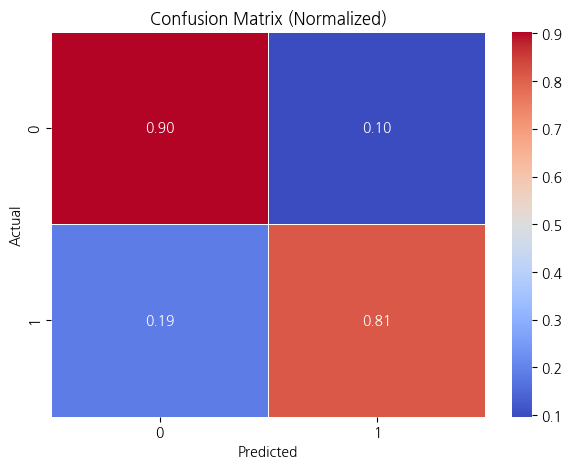

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgb_V10.predict(X_te_scaled)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [ ]:
ori_te_pred = model_lgb_V10.predict_proba(ori_te_scaled)[:,1]
ori_te_pred.shape

(393,)

### 특성 중요도

In [ ]:
df_feature_importances = pd.DataFrame(model_lgb_V10.feature_importances_, X_tr_scaled.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(22, 2)


,index,0
0,fare,1305
1,passengerid,1093
2,age,951
3,pclass,593
4,embarked,297
5,gender,277
6,avg_age_by_pclass,260
7,has_cabin,249
8,family_size,235
9,avg_fare_by_pclass,134


### 결과 정리

In [ ]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [ ]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

,model,parameters,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt,score_diff,auc_diff,total_diff
6,model_lgb_V10,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.868852,0.869565,0.913283,"[0.7335152353013964, 0.6859570785306655, 0.726...",22,"[fare, passengerid, age, pclass, embarked, gen...",2025-02-13 12:16:43,0.000713,0.043718,0.044431
1,model_lgb_V2,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.868852,0.869565,0.914536,"[0.731556192254988, 0.6879417768146249, 0.7230...",22,"[fare, passengerid, age, pclass, gender, embar...",2025-02-13 12:15:50,0.000713,0.044971,0.045684
2,model_lgb_V3,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.862022,0.864130,0.917669,"[0.7396065909427016, 0.7273871339093434, 0.732...",13,"[fare, passengerid, age, pclass, embarked, has...",2025-02-13 12:16:00,0.002109,0.053539,0.055647
0,model_lgb_V0,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.867486,0.864130,0.919925,"[0.7421581077190138, 0.7425022455978721, 0.742...",81,"[passengerid, fare, age, avg_fare_by_pclass, p...",2025-02-13 12:15:34,0.003356,0.055794,0.059150
5,model_lgb_V9,"{'subsample': 0.85, 'objective': 'binary', 'nu...",0.882514,0.869565,0.917168,"[0.7979353085048381, 0.7284675565176363, 0.775...",22,"[fare, passengerid, age, pclass, family_size, ...",2025-02-13 12:16:32,0.012948,0.047603,0.060551
4,model_lgb_V8,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.886612,0.869565,0.921554,"[0.8319468036514124, 0.8429776532871414, 0.848...",13,"[passengerid, fare, age, pclass, has_cabin, si...",2025-02-13 12:16:22,0.017047,0.051989,0.069035
3,model_lgb_V6,"{'subsample': 0.7, 'objective': 'binary', 'num...",0.889344,0.869565,0.922556,"[0.8205267207244362, 0.824560775783139, 0.8641...",13,"[fare, passengerid, age, pclass, sibsp, embark...",2025-02-13 12:16:12,0.019779,0.052991,0.072770


# model_lgbm_V10 (random search 진행) / submission_0213_7
- V2와의 차이 : 범주형 컬럼들이 무엇인지 명시하고, 훈련때 알려주기
- encoding X
- StandardScaler O

## Train & Test Split

In [ ]:
ori_train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [ ]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [ ]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

((732, 12), (184, 12))

## Data Preprocessing

In [ ]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [ ]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [ ]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Feature Extraction

#### pclass별 평균 나이

In [ ]:
# pclass별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_pclass'] = train.groupby('pclass')['age'].transform('mean')
test['avg_age_by_pclass'] = test.groupby('pclass')['age'].transform('mean')
ori_te['avg_age_by_pclass'] = ori_te.groupby('pclass')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 13) (184, 13) (393, 12)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018


#### embarked별 평균 나이

In [ ]:
# embarked별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_embarked'] = train.groupby('embarked')['age'].transform('mean')
test['avg_age_by_embarked'] = test.groupby('embarked')['age'].transform('mean')
ori_te['avg_age_by_embarked'] = ori_te.groupby('embarked')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 14) (184, 14) (393, 13)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433


#### pclass별 평균 요금

In [ ]:
# pclass별 평균 요금을 계산하여 새로운 컬럼 추가
train['avg_fare_by_pclass'] = train.groupby('pclass')['fare'].transform('mean')
test['avg_fare_by_pclass'] = test.groupby('pclass')['fare'].transform('mean')
ori_te['avg_fare_by_pclass'] = ori_te.groupby('pclass')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 15) (184, 15) (393, 14)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176


#### embarked별 평균 요금

In [ ]:
train['avg_fare_by_embarked'] = train.groupby('embarked')['fare'].transform('mean')
test['avg_fare_by_embarked'] = test.groupby('embarked')['fare'].transform('mean')
ori_te['avg_fare_by_embarked'] = ori_te.groupby('embarked')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 16) (184, 16) (393, 15)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418


#### 동승한 가족 인원수 컬럼 추가

In [ ]:
# sibsp : 동승한 형제/배우자의 수, parch: 동승한 부모/자녀의 수.
train['family_size'] = train['sibsp'] + train['parch'] + 1
test['family_size'] = test['sibsp'] + test['parch'] + 1
ori_te['family_size'] = ori_te['sibsp'] + ori_te['parch'] + 1

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 17) (184, 17) (393, 16)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1


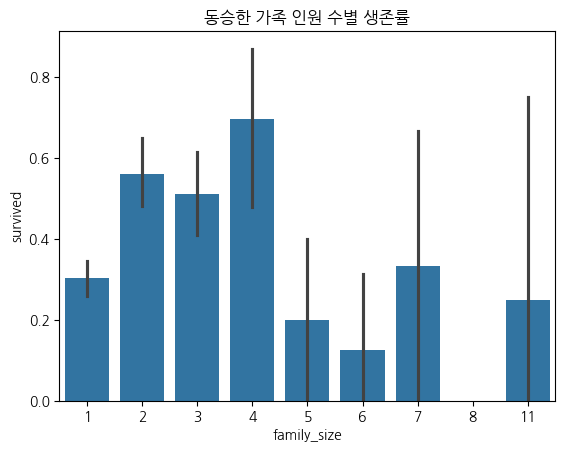

In [ ]:
sns.barplot(data=train, x='family_size', y='survived')
plt.title('동승한 가족 인원 수별 생존률')
plt.show()

#### 가족 인원 수를 기준으로 그룹화

In [ ]:
train['is_alone'] = (train['family_size'] == 1).astype(int)
test['is_alone'] = (test['family_size'] == 1).astype(int)
ori_te['is_alone'] = (ori_te['family_size'] == 1).astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 18) (184, 18) (393, 17)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1


#### cabin 컬럼의 값이 있으면 1, 없으면 0

In [ ]:
# Cabin 존재 여부를 나타내는 컬럼
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 19) (184, 19) (393, 18)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin
914,914,1,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
805,805,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,24.095018,29.068433,13.55176,25.140418,7,0,0
255,255,1,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,24.095018,29.068433,13.55176,25.140418,3,0,0
769,769,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,24.095018,28.948276,13.55176,14.147372,1,1,0
527,527,0,3,"Rintamaki, Mr. Matti",male,35.0,0,0,STON/O 2. 3101273,7.1250,NaN,S,24.095018,29.068433,13.55176,25.140418,1,1,0


### Data Cleaning

In [ ]:
train.isnull().sum().sort_values(ascending=False)

,0
cabin,580
age,135
passengerid,0
is_alone,0
family_size,0
avg_fare_by_embarked,0
avg_fare_by_pclass,0
avg_age_by_embarked,0
avg_age_by_pclass,0
embarked,0


In [ ]:
test.isnull().sum().sort_values(ascending=False)

,0
cabin,138
age,45
avg_fare_by_embarked,1
avg_age_by_embarked,1
embarked,1
passengerid,0
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


In [ ]:
ori_te.isnull().sum().sort_values(ascending=False)

,0
cabin,296
age,83
embarked,1
avg_fare_by_embarked,1
avg_age_by_embarked,1
fare,1
is_alone,0
family_size,0
avg_fare_by_pclass,0
avg_age_by_pclass,0


In [ ]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked와 cabin에 대해 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

(914    21.414891
 805     6.000000
 255     1.000000
 769    70.500000
 527    35.000000
          ...    
 403     1.000000
 824    34.000000
 879    10.000000
 214    24.000000
 636    70.000000
 Name: age, Length: 732, dtype: float64,
 914     7.7333
 805    31.2750
 255    12.1833
 769     7.7500
 527     7.1250
         ...   
 403    15.7417
 824     8.0500
 879    24.1500
 214    79.2000
 636    71.0000
 Name: fare, Length: 732, dtype: float64,
 'S')

In [ ]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

# 'avg_fare_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'fare' 컬럼의 평균으로 결측치 대체
train['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
test['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
ori_te['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)

# 'avg_age_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'age' 컬럼의 평균으로 결측치 대체
train['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
test['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
ori_te['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

<ipython-input-371-e249aeb7e77b>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['age'].fillna(age_mean, inplace=True)
<ipython-input-371-e249aeb7e77b>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [ ]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 19) / (184, 19)
after: (732, 16) / (184, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone          

In [ ]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [ ]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin'],
      dtype='object')

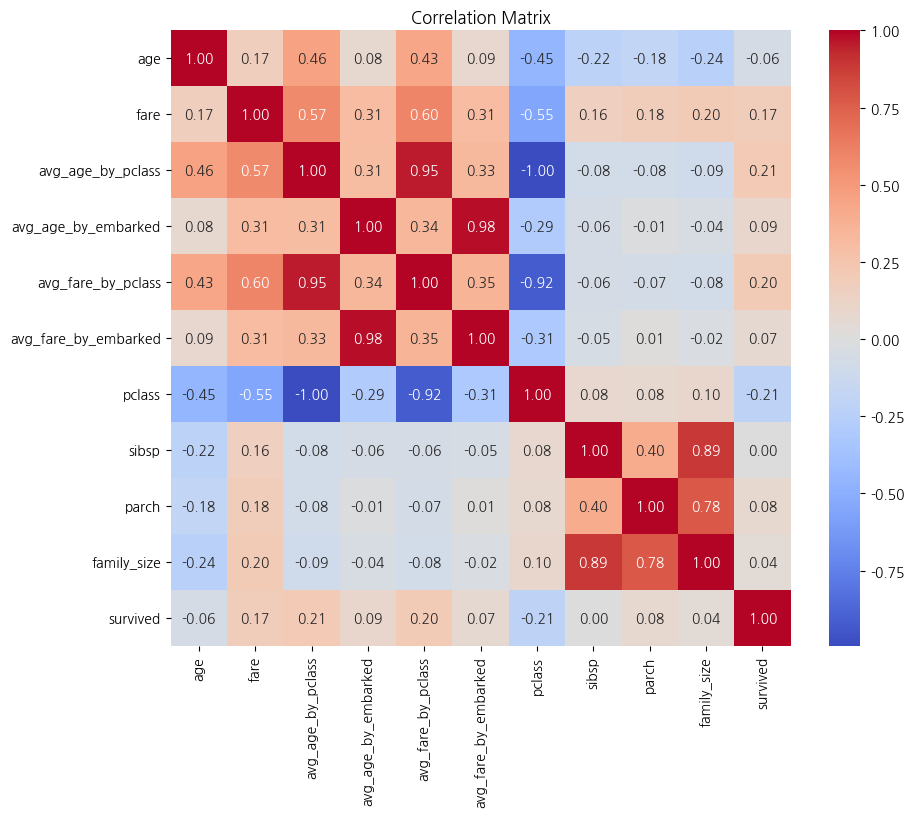

In [ ]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
    'pclass', 'sibsp', 'parch', 'family_size'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

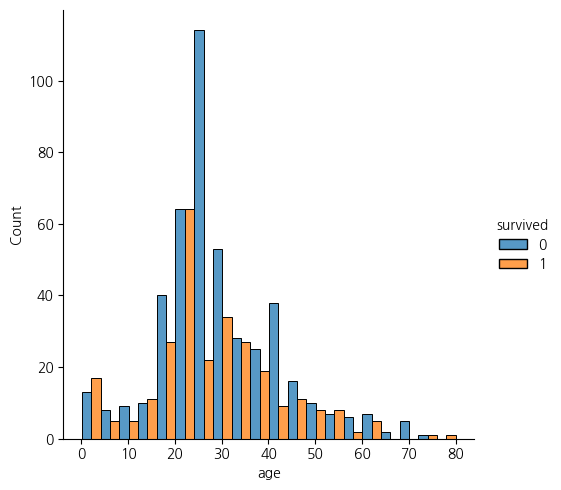

In [ ]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [ ]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5757575757575758

In [ ]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.2777777777777778

In [ ]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3676680972818312

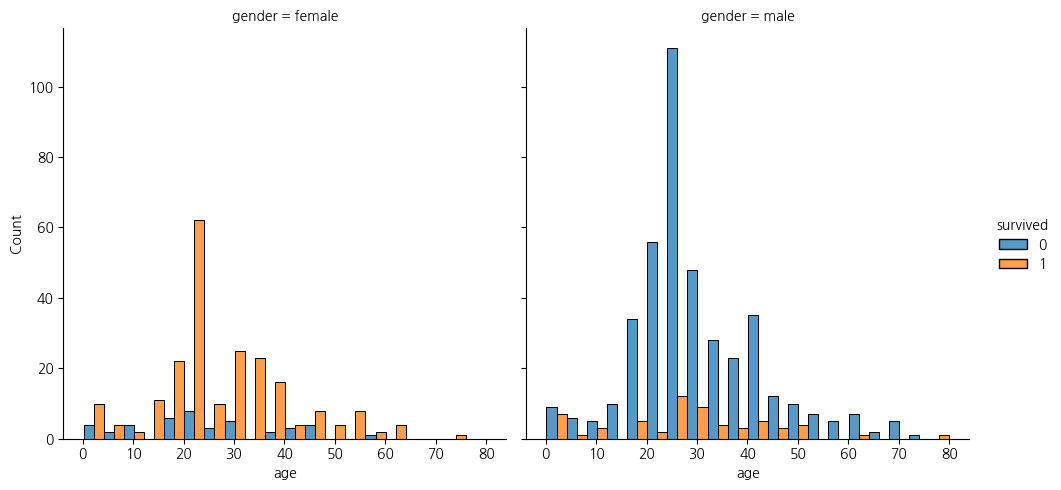

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 16), (184, 16), (393, 15)
컬럼 생성 이후 : (732, 17), (184, 17), (393, 16)


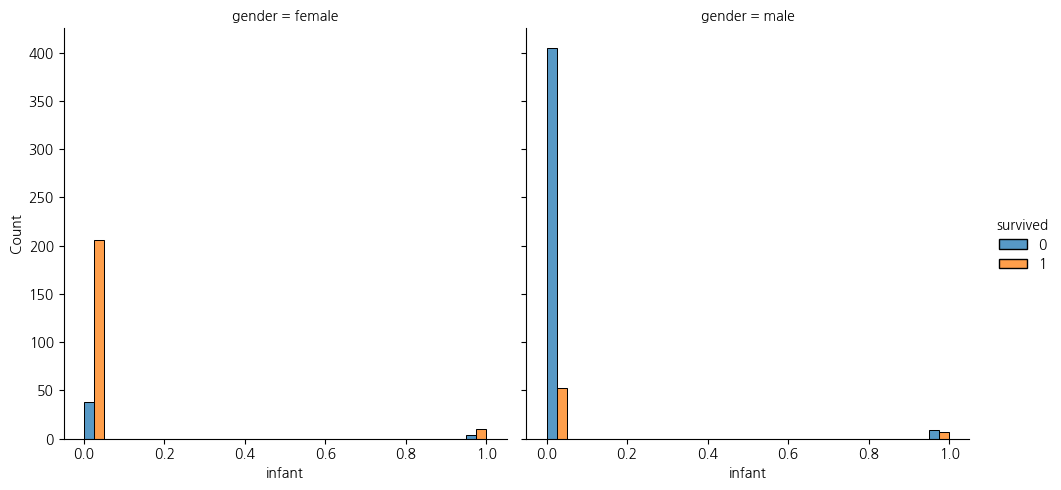

In [ ]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 17), (184, 17), (393, 16)
컬럼 생성 이후 : (732, 18), (184, 18), (393, 17)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0


##### pclass & gender

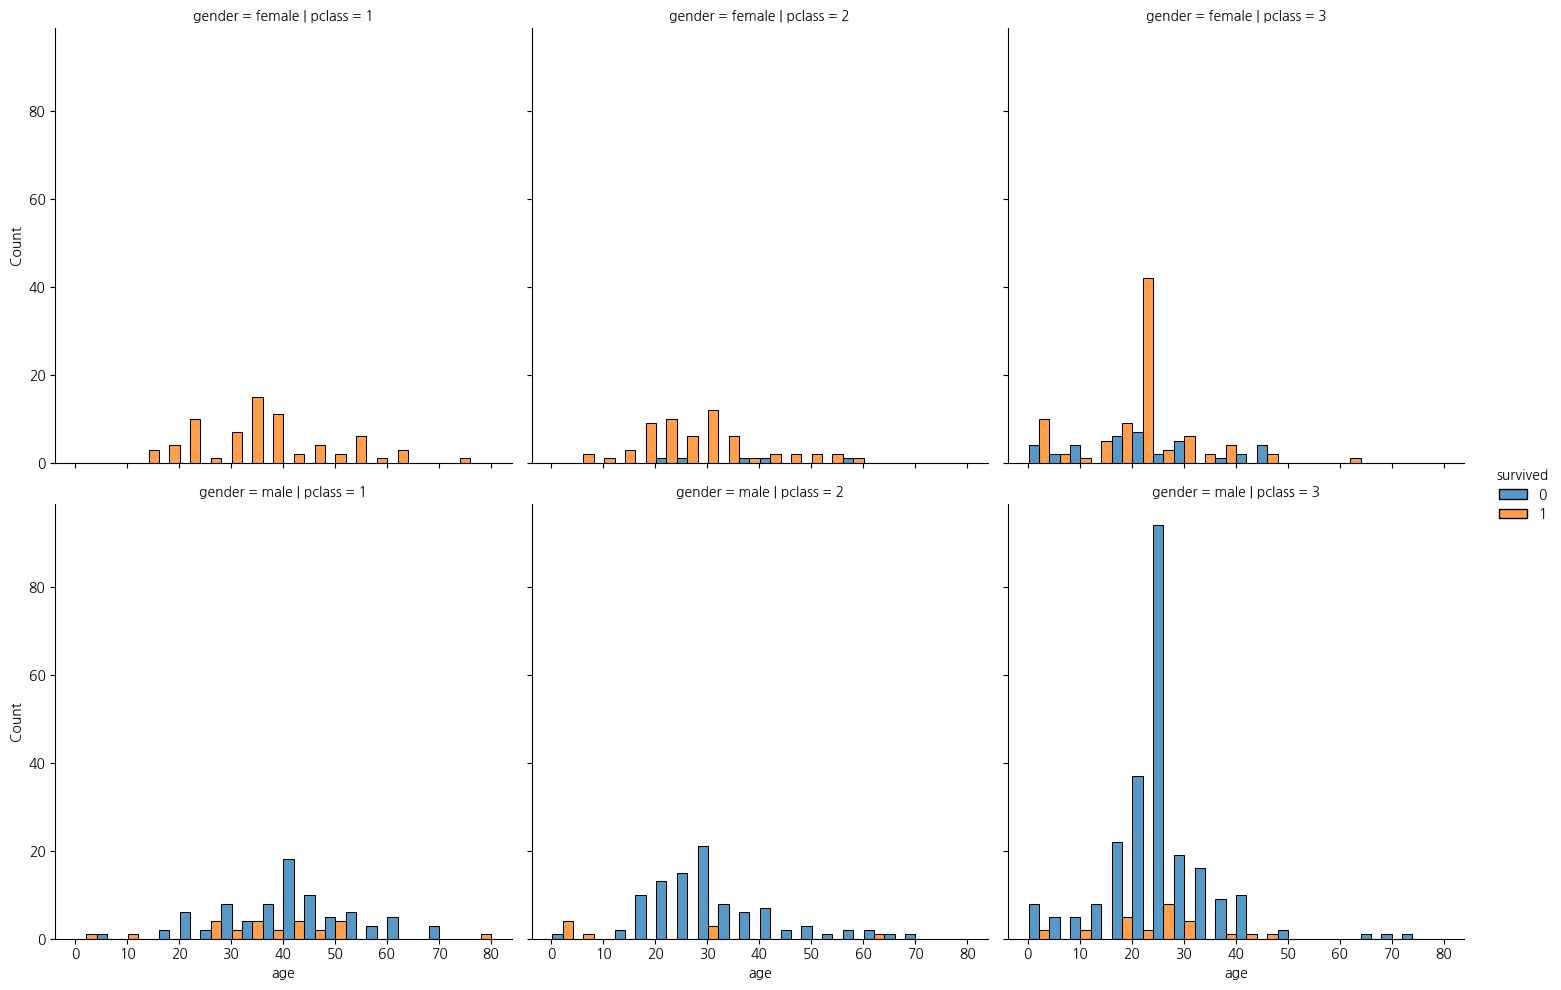

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 18), (184, 18), (393, 17)
컬럼 생성 이후 : (732, 19), (184, 19), (393, 18)


In [ ]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
       dtype='object'),
 19)

In [ ]:
train.shape, test.shape, ori_te.shape

((732, 19), (184, 19), (393, 18))

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [ ]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
      dtype='object')

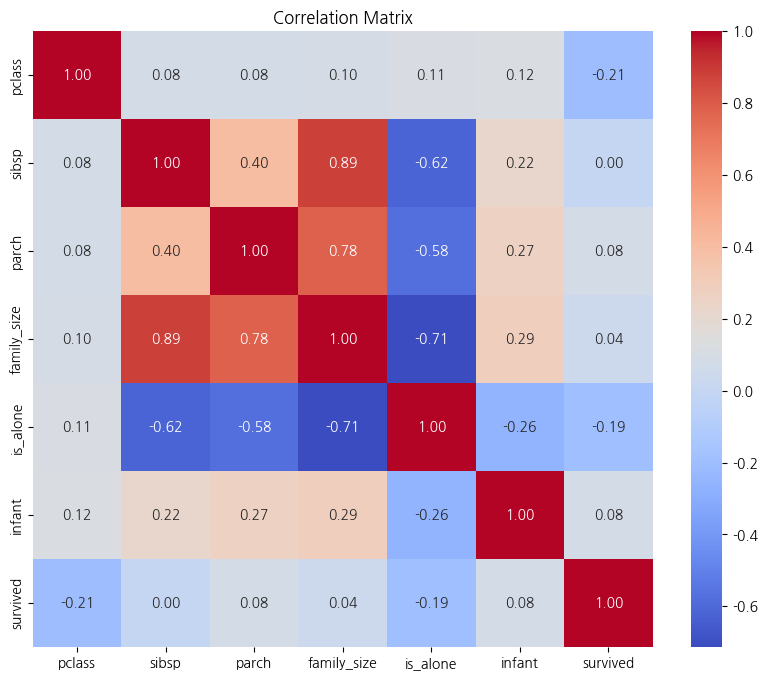

In [ ]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'family_size', 'is_alone', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 19), (184, 19), (393, 18)
컬럼 생성 이후 : (732, 20), (184, 20), (393, 19)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,avg_age_by_embarked,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,29.068433,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,29.068433,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,28.948276,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,29.068433,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3


##### infant & family_size

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_family_size 컬럼 생성: 어린이 여부와 가족 크기 결합
train['infant_family_size'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
test['infant_family_size'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
ori_te['infant_family_size'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 20), (184, 20), (393, 19)
컬럼 생성 이후 : (732, 21), (184, 21), (393, 20)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_pclass,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,13.55176,14.147372,1,1,0,0,female_0,female_3,0_3,0_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,13.55176,25.140418,7,0,0,0,female_0,female_3,0_3,0_7
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,13.55176,25.140418,3,0,0,1,female_1,female_3,1_3,1_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,13.55176,14.147372,1,1,0,0,male_0,male_3,0_3,0_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,13.55176,25.140418,1,1,0,0,male_0,male_3,0_3,0_1


##### pclass & is_alone

In [ ]:

print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_is_alone 컬럼 생성: 객실 등급과 단독 탑승 여부 결합
train['pclass_is_alone'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
test['pclass_is_alone'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
ori_te['pclass_is_alone'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 21), (184, 21), (393, 20)
컬럼 생성 이후 : (732, 22), (184, 22), (393, 21)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,avg_fare_by_embarked,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,14.147372,1,1,0,0,female_0,female_3,0_3,0_1,3_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,25.140418,7,0,0,0,female_0,female_3,0_3,0_7,3_0
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,25.140418,3,0,0,1,female_1,female_3,1_3,1_3,3_0
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,14.147372,1,1,0,0,male_0,male_3,0_3,0_1,3_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,25.140418,1,1,0,0,male_0,male_3,0_3,0_1,3_1


##### pclass_family_size

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_family_size 컬럼 생성: 객실 등급과 가족 크기 결합
train['pclass_family_size'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
test['pclass_family_size'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
ori_te['pclass_family_size'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 22), (184, 22), (393, 21)
컬럼 생성 이후 : (732, 23), (184, 23), (393, 22)


,passengerid,survived,pclass,gender,age,sibsp,parch,fare,embarked,avg_age_by_pclass,...,family_size,is_alone,has_cabin,infant,gender_infant,gender_pclass,infant_pclass,infant_family_size,pclass_is_alone,pclass_family_size
914,914,1,3,female,21.414891,0,0,7.7333,Q,24.095018,...,1,1,0,0,female_0,female_3,0_3,0_1,3_1,3_1
805,805,0,3,female,6.000000,4,2,31.2750,S,24.095018,...,7,0,0,0,female_0,female_3,0_3,0_7,3_0,3_7
255,255,1,3,female,1.000000,1,1,12.1833,S,24.095018,...,3,0,0,1,female_1,female_3,1_3,1_3,3_0,3_3
769,769,0,3,male,70.500000,0,0,7.7500,Q,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1
527,527,0,3,male,35.000000,0,0,7.1250,S,24.095018,...,1,1,0,0,male_0,male_3,0_3,0_1,3_1,3_1


In [ ]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### Scaling

In [ ]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'pclass', 'gender', 'age', 'sibsp', 'parch', 'fare',
        'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg

In [ ]:
print(f"train: {train.shape}, test: {test.shape}, ori_te: {ori_te.shape}")

train: (732, 23), test: (184, 23), ori_te: (393, 22)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

In [ ]:
print(f"{len(train.columns)}, {len(test.columns)}, {len(ori_te.columns)}")

# 범주형
cat_features = [
    'pclass', 'gender', 'embarked', 'sibsp', 'parch', 'has_cabin', 'infant',
    'is_alone', 'gender_infant', 'gender_pclass', 'infant_pclass',
    'infant_family_size', 'pclass_is_alone', 'pclass_family_size'
]

# 수치형
num_features = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked',
    'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size'
]

print(f"범주형 변수 개수: {len(cat_features)}, 수치형 변수 개수: {len(num_features)}")

excluded_features = set(train.columns) - set(cat_features) - set(num_features)
print(f"포함되지 않은 컬럼들: {excluded_features}")

23, 23, 22
범주형 변수 개수: 14, 수치형 변수 개수: 7
포함되지 않은 컬럼들: {'passengerid', 'survived'}


In [ ]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   passengerid           732 non-null    int64   
 1   survived              732 non-null    int64   
 2   pclass                732 non-null    category
 3   gender                732 non-null    category
 4   age                   732 non-null    float64 
 5   sibsp                 732 non-null    category
 6   parch                 732 non-null    category
 7   fare                  732 non-null    float64 
 8   embarked              732 non-null    category
 9   avg_age_by_pclass     732 non-null    float64 
 10  avg_age_by_embarked   732 non-null    float64 
 11  avg_fare_by_pclass    732 non-null    float64 
 12  avg_fare_by_embarked  732 non-null    float64 
 13  family_size           732 non-null    int64   
 14  is_alone              732 non-null    category
 15  has_cabin

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

((732, 22), (732,), (184, 22), (184,), (393, 22))

In [ ]:
print(f"before: {X_tr.shape}, {X_te.shape}, {ori_te.shape}")

scaler = StandardScaler()

X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()
ori_te_scaled = ori_te.copy()

X_tr_scaled[num_features] = scaler.fit_transform(X_tr[num_features])
X_te_scaled[num_features] = scaler.transform(X_te[num_features])
ori_te_scaled[num_features] = scaler.transform(ori_te[num_features])

print(f"after: {X_tr_scaled.shape}, {X_te_scaled.shape}, {ori_te_scaled.shape}")

before: (732, 22), (184, 22), (393, 22)
after: (732, 22), (184, 22), (393, 22)


## Training

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [ ]:
# reset_seeds()
# model_name = 'model_lgb_V10'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'n_estimators': list(range(400, 800, 50)),  # 최적값 600 기준 ±200 범위
#     'learning_rate': [0.005, 0.01, 0.02, 0.05],  # 작은 학습률
#     'max_depth': list(range(5, 20, 3)) + [None],  # 깊이 제한
#     'num_leaves': list(range(20, 150, 20)),  # 리프 노드 개수 최적화
#     'min_child_samples': list(range(10, 41, 5)),  # 최소 샘플 개수 설정
#     'colsample_bytree': [0.4, 0.5, 0.6, 0.7],  # 특성 샘플링 비율
#     'subsample': [0.7, 0.8, 0.9, 1.0],  # 데이터 샘플링 비율
#     'boosting_type': ['gbdt', 'dart'],  # gbdt와 dart 비교
#     'objective': ['binary'],  # 바이너리 분류
#     'metric': ['auc']  # AUC 성능 최적화
# }


# # LightGBM 모델 초기화
# model_lgb_V10 = lgb.LGBMClassifier(random_state=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_lgb_V10, param_distributions=param_dist,
#     n_iter=300, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
# )

# random_search.fit(X_tr_scaled, y_tr, categorical_feature=cat_features)

In [ ]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [ ]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_lgb_V10 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
# print(f'{model_lgb_V10} : {X_tr_scaled.shape} / {y_tr.shape}')

# # 모델 학습
# model_lgb_V10.fit(X_tr_scaled, y_tr, categorical_feature=cat_features)

In [ ]:
reset_seeds()
model_name = 'model_lgb_V10'

parameters = {
    'subsample': 0.5,
    'objective': 'binary',
    'num_leaves': 30,
    'n_estimators': 550,
    'min_child_weight': 10,
    'min_child_samples': 15,
    'metric': 'auc',
    'max_depth': 29,
    'learning_rate': 0.01,
    'colsample_bytree': 0.5,
    'boosting_type': 'dart'
}

# LightGBM 모델 초기화
model_lgb_V10 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

model_lgb_V10.fit(X_tr_scaled, y_tr)

[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5)

## Evaluation (평가)

In [ ]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V10.score(X_tr_scaled, y_tr)
# - Test data
score_te_lgb = model_lgb_V10.score(X_te_scaled, y_te)

print(f'{model_lgb_V10} : {score_tr_lgb}, {score_te_lgb}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5) : 0.8688524590163934, 0.8695652173913043


### AUC 점수

In [ ]:
y_pred = model_lgb_V10.predict_proba(X_te_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V10}: {auc_te}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5): 0.9132832080200501


### 혼동행렬

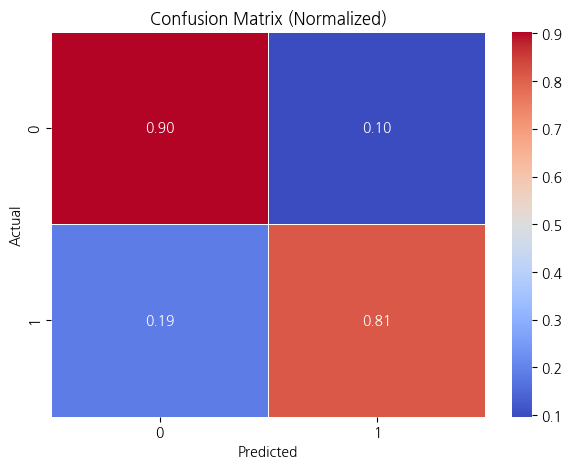

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgb_V10.predict(X_te_scaled)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [ ]:
ori_te_pred = model_lgb_V10.predict_proba(ori_te_scaled)[:,1]
ori_te_pred.shape

(393,)

### 특성 중요도

In [ ]:
df_feature_importances = pd.DataFrame(model_lgb_V10.feature_importances_, X_tr_scaled.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(22, 2)


,index,0
0,fare,1305
1,passengerid,1093
2,age,951
3,pclass,593
4,embarked,297
5,gender,277
6,avg_age_by_pclass,260
7,has_cabin,249
8,family_size,235
9,avg_fare_by_pclass,134


### 결과 정리

In [ ]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [ ]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

,model,parameters,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt,score_diff,auc_diff,total_diff
6,model_lgb_V10,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.868852,0.869565,0.913283,"[0.7335152353013964, 0.6859570785306655, 0.726...",22,"[fare, passengerid, age, pclass, embarked, gen...",2025-02-13 12:16:43,0.000713,0.043718,0.044431
1,model_lgb_V2,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.868852,0.869565,0.914536,"[0.731556192254988, 0.6879417768146249, 0.7230...",22,"[fare, passengerid, age, pclass, gender, embar...",2025-02-13 12:15:50,0.000713,0.044971,0.045684
2,model_lgb_V3,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.862022,0.864130,0.917669,"[0.7396065909427016, 0.7273871339093434, 0.732...",13,"[fare, passengerid, age, pclass, embarked, has...",2025-02-13 12:16:00,0.002109,0.053539,0.055647
0,model_lgb_V0,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.867486,0.864130,0.919925,"[0.7421581077190138, 0.7425022455978721, 0.742...",81,"[passengerid, fare, age, avg_fare_by_pclass, p...",2025-02-13 12:15:34,0.003356,0.055794,0.059150
5,model_lgb_V9,"{'subsample': 0.85, 'objective': 'binary', 'nu...",0.882514,0.869565,0.917168,"[0.7979353085048381, 0.7284675565176363, 0.775...",22,"[fare, passengerid, age, pclass, family_size, ...",2025-02-13 12:16:32,0.012948,0.047603,0.060551
4,model_lgb_V8,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.886612,0.869565,0.921554,"[0.8319468036514124, 0.8429776532871414, 0.848...",13,"[passengerid, fare, age, pclass, has_cabin, si...",2025-02-13 12:16:22,0.017047,0.051989,0.069035
3,model_lgb_V6,"{'subsample': 0.7, 'objective': 'binary', 'num...",0.889344,0.869565,0.922556,"[0.8205267207244362, 0.824560775783139, 0.8641...",13,"[fare, passengerid, age, pclass, sibsp, embark...",2025-02-13 12:16:12,0.019779,0.052991,0.072770


# Submission

In [ ]:
default_submission = pd.read_csv(args.default_submission)
default_submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [ ]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

,model,parameters,score_tr,score_te,auc_te,ori_te_pred,len_features,feaute_importances,create_dt,score_diff,auc_diff,total_diff
6,model_lgb_V10,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.868852,0.869565,0.913283,"[0.7335152353013964, 0.6859570785306655, 0.726...",22,"[fare, passengerid, age, pclass, embarked, gen...",2025-02-13 12:16:43,0.000713,0.043718,0.044431
1,model_lgb_V2,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.868852,0.869565,0.914536,"[0.731556192254988, 0.6879417768146249, 0.7230...",22,"[fare, passengerid, age, pclass, gender, embar...",2025-02-13 12:15:50,0.000713,0.044971,0.045684
7,model_lgb_V11,"{'subsample': 0.85, 'objective': 'binary', 'nu...",0.880482,0.869565,0.908960,"[0.8608905465266997, 0.8114241167200991, 0.845...",22,"[fare, age, family_size, avg_age_by_embarked, ...",2025-02-13 12:16:51,0.010917,0.039395,0.050312
2,model_lgb_V3,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.862022,0.864130,0.917669,"[0.7396065909427016, 0.7273871339093434, 0.732...",13,"[fare, passengerid, age, pclass, embarked, has...",2025-02-13 12:16:00,0.002109,0.053539,0.055647
0,model_lgb_V0,"{'subsample': 0.5, 'objective': 'binary', 'num...",0.867486,0.864130,0.919925,"[0.7421581077190138, 0.7425022455978721, 0.742...",81,"[passengerid, fare, age, avg_fare_by_pclass, p...",2025-02-13 12:15:34,0.003356,0.055794,0.059150
5,model_lgb_V9,"{'subsample': 0.85, 'objective': 'binary', 'nu...",0.882514,0.869565,0.917168,"[0.7979353085048381, 0.7284675565176363, 0.775...",22,"[fare, passengerid, age, pclass, family_size, ...",2025-02-13 12:16:32,0.012948,0.047603,0.060551
4,model_lgb_V8,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.886612,0.869565,0.921554,"[0.8319468036514124, 0.8429776532871414, 0.848...",13,"[passengerid, fare, age, pclass, has_cabin, si...",2025-02-13 12:16:22,0.017047,0.051989,0.069035
3,model_lgb_V6,"{'subsample': 0.7, 'objective': 'binary', 'num...",0.889344,0.869565,0.922556,"[0.8205267207244362, 0.824560775783139, 0.8641...",13,"[fare, passengerid, age, pclass, sibsp, embark...",2025-02-13 12:16:12,0.019779,0.052991,0.072770


In [ ]:
default_submission['survived'] = df_results.iloc[0]['ori_te_pred']

# 결측값 확인 및 결과 출력
print(f'{default_submission.isnull().sum().sum()}')
default_submission.head(10)

0


,passengerid,survived
0,916,0.733515
1,917,0.685957
2,918,0.726216
3,919,0.206330
4,920,0.814524
5,921,0.712723
6,922,0.247813
7,923,0.231576
8,924,0.553190
9,925,0.255387


In [ ]:
default_submission.to_csv(args.submission_csv, header=True, index=False)

In [ ]:
# 방금 제출한 csv 파일의 파일명 출력
submission_filename = os.path.basename(args.submission_csv)
print(submission_filename)

submission_0213_7.csv
